In [17]:
# neural network all tools 
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
# data visualization tools
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tqdm.notebook as tqdm
#image manipulation tools
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score,classification_report
from PIL import Image
import cv2
import os
import shutil


In [18]:
df = pd.read_excel(r"C:\Users\mail2\Desktop\ml\covid_data_trainer\COVID-19_Radiography_Dataset\COVID.metadata.xlsx")
selected_df= df['FILE NAME']+'.png'
images = selected_df.values.tolist()
df['FILE NAME']+'.png'

0          COVID-1.png
1          COVID-2.png
2          COVID-3.png
3          COVID-4.png
4          COVID-5.png
             ...      
3611    COVID-3612.png
3612    COVID-3613.png
3613    COVID-3614.png
3614    COVID-3615.png
3615    COVID-3616.png
Name: FILE NAME, Length: 3616, dtype: object

this is how we import data

In [ ]:
os.makedirs("./COVID19/train/covid")
os.makedirs("./COVID19/train/normal")

In [20]:
covid_p=("./COVID19/train/covid")
normal_p=("./COVID19/train/normal")

this is how we coppy data from one directory to ther using os and shulit


In [ ]:
for image in images:
    shutil.copy(os.path.join(r'C:\Users\mail2\Desktop\ml\covid_data_trainer\COVID-19_Radiography_Dataset\COVID\images', image), os.path.join(covid_p, image))

In [21]:
df = pd.read_excel(r"C:\Users\mail2\Desktop\ml\covid_data_trainer\COVID-19_Radiography_Dataset\Normal.metadata.xlsx")
selected_df= df['FILE NAME']+'.png'
images = selected_df.values.tolist()
df['FILE NAME']+'.png'

0            NORMAL-1.png
1            NORMAL-2.png
2            NORMAL-3.png
3            NORMAL-4.png
4            NORMAL-5.png
               ...       
10187    NORMAL-10188.png
10188    NORMAL-10189.png
10189    NORMAL-10190.png
10190    NORMAL-10191.png
10191    NORMAL-10192.png
Name: FILE NAME, Length: 10192, dtype: object

In [ ]:
images= os.listdir(r"C:\Users\mail2\Desktop\ml\covid_data_trainer\COVID-19_Radiography_Dataset\Normal\images")[:3616]
for image in images:
    shutil.copy(os.path.join(r'C:\Users\mail2\Desktop\ml\covid_data_trainer\COVID-19_Radiography_Dataset\Normal\images', image), os.path.join(normal_p, image))

In [23]:
DATA_PATH = './COVID19/train'

In [24]:
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i]= len(os.listdir(os.path.join(DATA_PATH,i)))
image_count

{'covid': 3616, 'normal': 3616}

Plotting Distribution of Each Classes

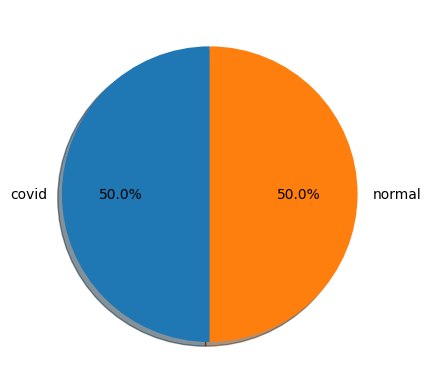

In [25]:
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

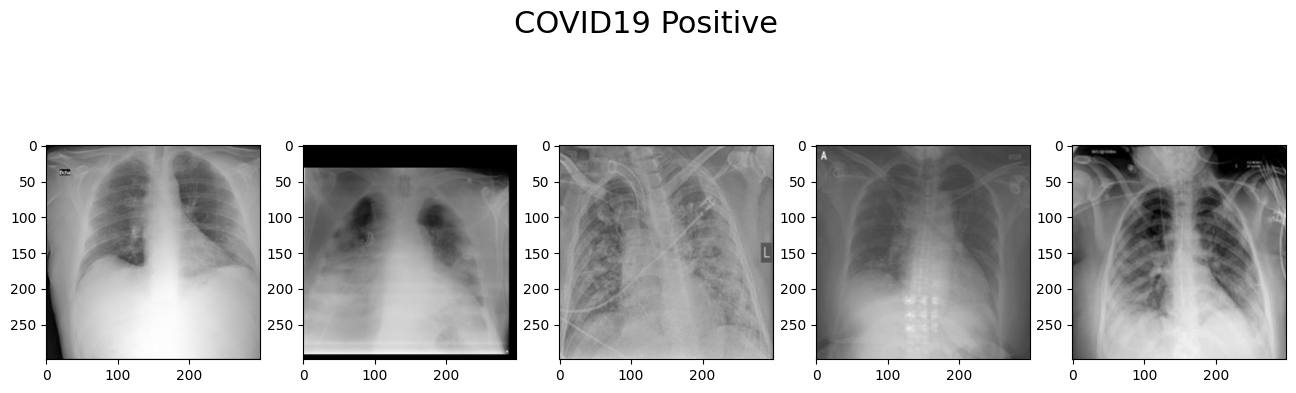

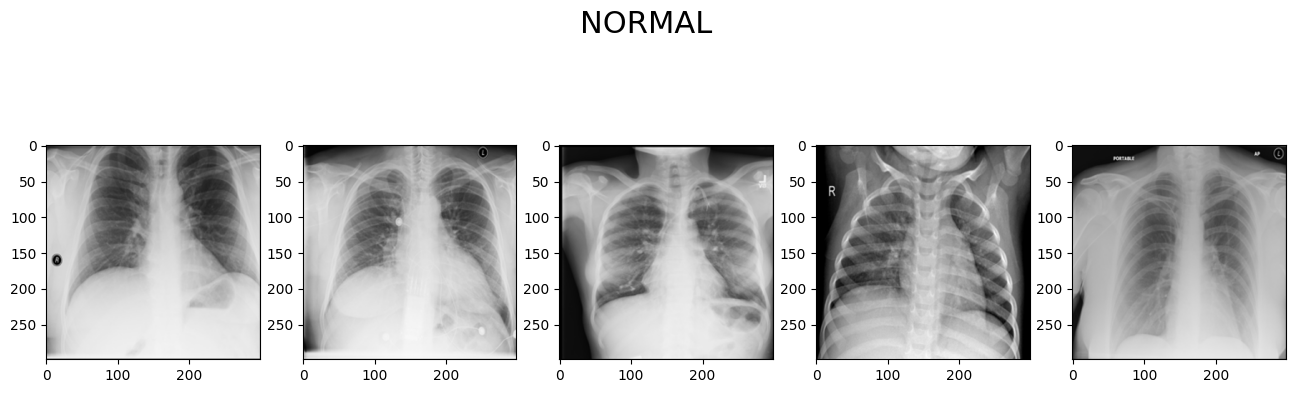

In [26]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(covid_p)
shuffle(img_paths)

for i,image in enumerate(img_paths[:5]):
    img = cv2.imread(os.path.join(covid_p, image))
    plt.subplot(1,5, i+1)
    plt.imshow(img)
# fig.show()

fig = plt.figure(figsize=(16,5))
fig.suptitle("NORMAL", size=22)
img_paths = os.listdir(normal_p)
shuffle(img_paths)
for i,image in enumerate(img_paths[:5]):
    img = cv2.imread(os.path.join(normal_p, image))
    plt.subplot(1,5, i+1)
    plt.imshow(img)
# fig.show()

In [27]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                    transforms.Resize((227,227)), 
                    #Resizes all images into same dimension
                    transforms.RandomRotation(10), 
                    # Rotates the images upto Max of 10 Degrees
                    transforms.RandomHorizontalFlip(p=0.4), 
                    #Performs Horizantal Flip over images 
                    transforms.ToTensor(), 
                    # Coverts into Tensors
                    transforms.Normalize(mean = mean_nums, std=std_nums)]), 
                    # Normalizes
                    "val": transforms.Compose([
                    transforms.Resize((227,227)), 
                    #Performs Crop at Center and resizes it to 150x150
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [28]:
def load_split_train_test(datadir, valid_size=.2):
    train_data = datasets.ImageFolder(datadir, transform=data_transforms['train'])
    test_data = datasets.ImageFolder(datadir, transform=data_transforms['val'])
    num_train = len(train_data)
    indexes = list(range(num_train))
    split = int(np.floor(valid_size*num_train))
    np.random.shuffle(indexes)
    train, test = indexes[split:], indexes[:split]
    dataset_size = {"train": len(train), "val": len(test)}
    # Sampler for splitting train and val images
    train_sampler = SubsetRandomSampler(train)
    test_sampler = SubsetRandomSampler(test)
    trainloader = torch.utils.data.DataLoader(train_data,
                                              sampler=train_sampler, batch_size=16)  
    # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                                             sampler=test_sampler, batch_size=16)
    return trainloader, testloader, dataset_size


trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train": trainloader, "val": valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train', 'val']}
class_names = trainloader.dataset.classes
print(class_names)


['covid', 'normal']


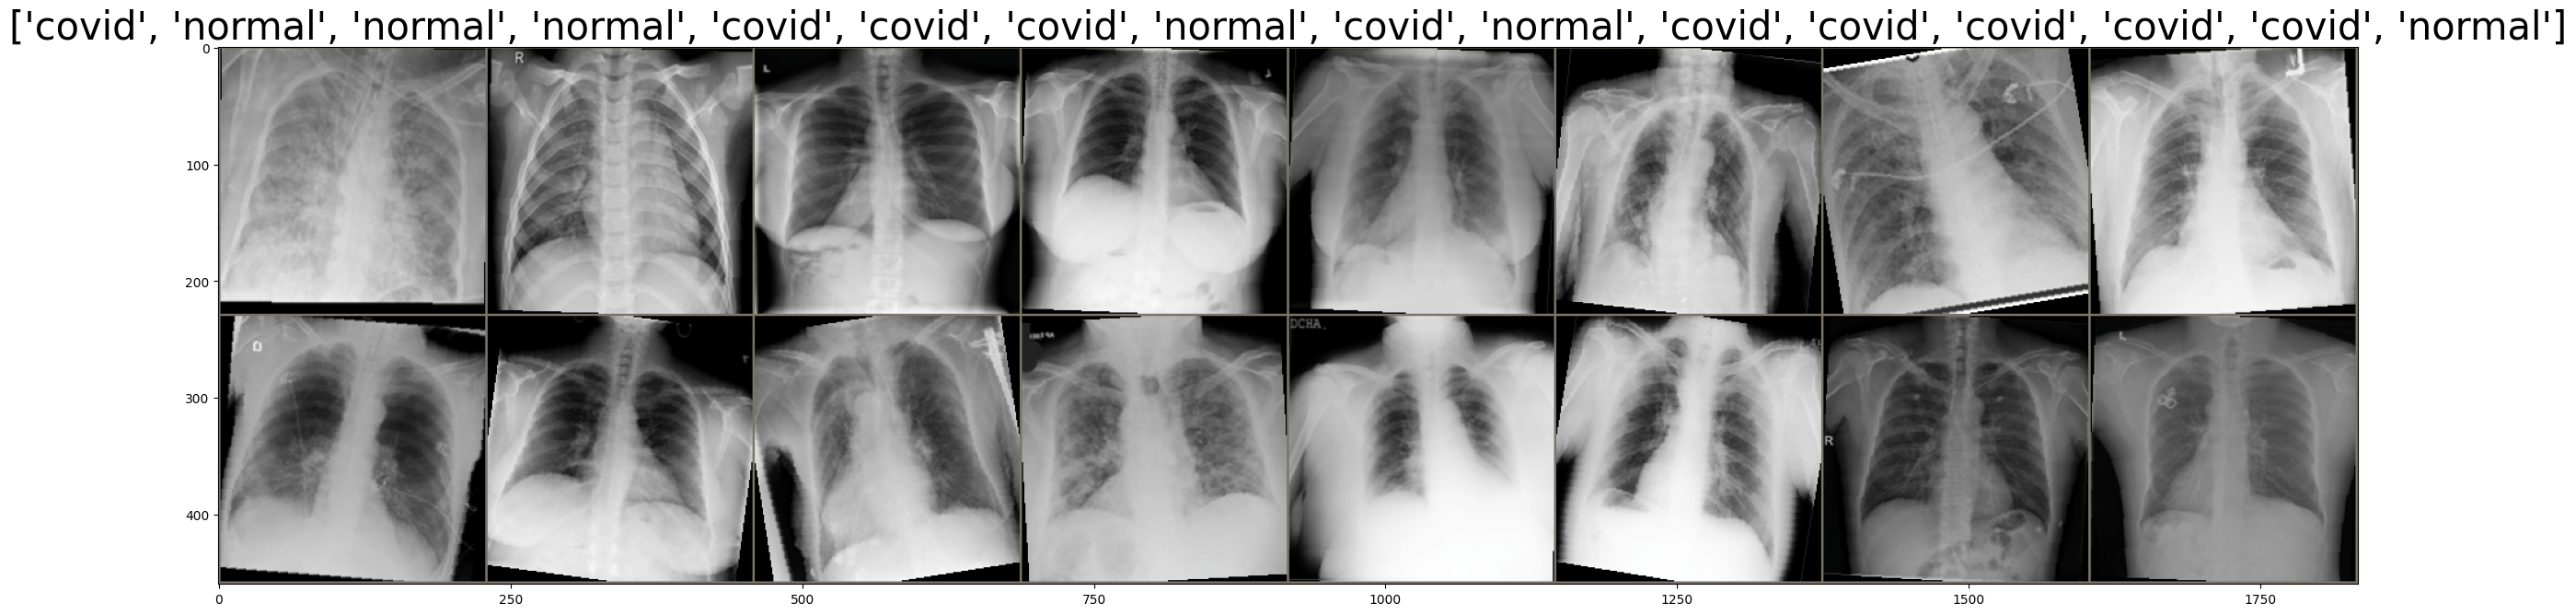

In [29]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [30]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")


Training on CPU... May the force be with you...


In [31]:
class VGG16_Model(nn.Module):
    # model = models.vgg16(pretrained=pretrained) 
    # Returns Defined Densenet model with weights trained on ImageNet
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer9 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer10 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer12 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer13 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8*8*512, 4096),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU()
        )
        self.denselayer = nn.Sequential(
            nn.Linear(4096,512),
            nn.Dropout(0.2),
            nn.Linear(512,128),
            nn.Dropout(0.1),
            nn.Linear(128,32),
            nn.Dropout(0.1),
            nn.Linear(32,2),
        )
    def forward(self,x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = self.layer5(out)
        # print(out.shape)
        out = self.layer6(out)
        # print(out.shape)
        out = self.layer7(out)
        # print(out.shape)
        out = self.layer8(out)
        # print(out.shape)
        out = self.layer9(out)
        # print(out.shape)
        out = self.layer10(out)
        # print(out.shape)
        out = self.layer11(out)
        # print(out.shape)
        out = self.layer12(out)
        # print(out.shape)
        out = self.layer13(out)
        print(out.shape)
        print(out.size(0))
        out = out.reshape(out.size(0),-1)
        print(out.shape)
        out = self.fc(out)
        print(out.shape)
        out = self.fc1(out)
        # print(out.shape)
        out = self.denselayer(out)
        # print(out.shape)
        return out
    # num_ftrs = model.classifier.in_features 
    # Get the number of features output from CNN layer
    # model.classifier = nn.Linear(num_ftrs, len(class_names)) 
    # Overwrites the Classifier layer with custom defined layer for transfer learning
    # model = model.to(device) 
    # Transfer the Model to GPU if available

model = VGG16_Model()

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Learning Scheduler

In [32]:
print(model)

VGG16_Model(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [33]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
167893794


In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('[INFO] :Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            i=0
            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()
            for i ,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    print(outputs, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if phase == 'train':
                        scheduler.step()

                    # We want variables to hold the loss statistics
                    current_loss += loss.item() * inputs.size(0)
                    current_corrects += torch.sum(preds == labels.data)
                    val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                    if(i%20==0):
                        print('=')
                    i+=1;
            print('>')
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [43]:
!pip install torchsummary

In [44]:
from torchsummary import summary

In [45]:
summary(model,([[3,277,277]]))

torch.Size([2, 512, 8, 8])
2
torch.Size([2, 32768])
torch.Size([2, 4096])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 277, 277]           1,792
       BatchNorm2d-2         [-1, 64, 277, 277]             128
              ReLU-3         [-1, 64, 277, 277]               0
            Conv2d-4         [-1, 64, 277, 277]          36,928
       BatchNorm2d-5         [-1, 64, 277, 277]             128
              ReLU-6         [-1, 64, 277, 277]               0
         MaxPool2d-7         [-1, 64, 138, 138]               0
            Conv2d-8        [-1, 128, 138, 138]          73,856
       BatchNorm2d-9        [-1, 128, 138, 138]             256
             ReLU-10        [-1, 128, 138, 138]               0
           Conv2d-11        [-1, 128, 138, 138]         147,584
      BatchNorm2d-12        [-1, 128, 138, 138]             256
             ReLU-13        [

In [46]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

[INFO] :Epoch 1/1
torch.Size([16, 512, 7, 7])
16
torch.Size([16, 25088])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x25088 and 32768x4096)

visualize_model(base_model)
plt.show()